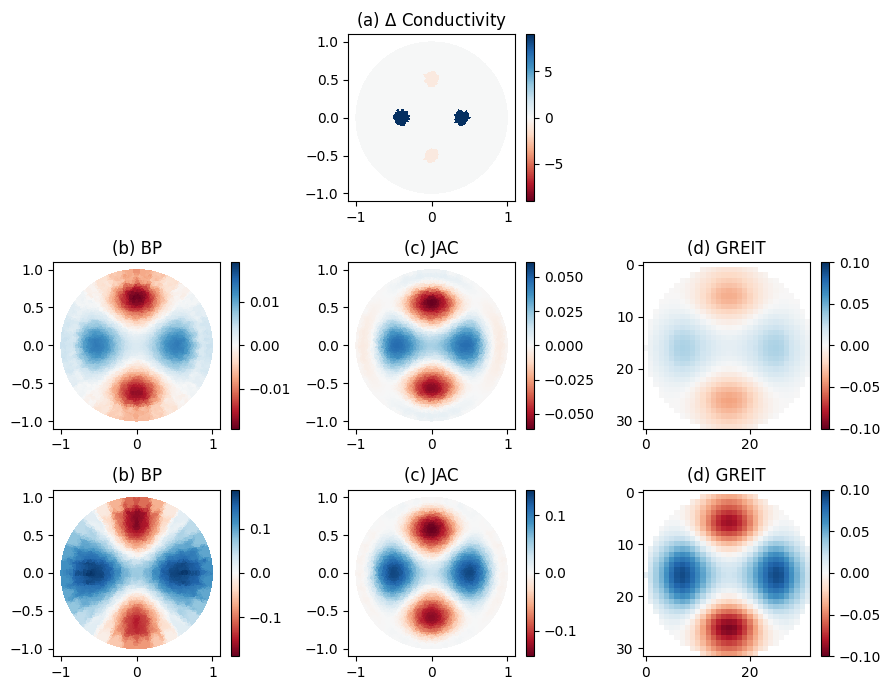

In [3]:
#adjacent injection pattern
""" Figure03 for softx """
# Copyright (c) Benyuan Liu. All Rights Reserved.
# Distributed under the (new) BSD License. See LICENSE.txt for more info.
from __future__ import division, absolute_import, print_function

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec

import pyeit.mesh as mesh
from pyeit.eit.fem import EITForward
from pyeit.eit.fem import Forward
from pyeit.eit.interp2d import sim2pts
import pyeit.eit.protocol as protocol
from pyeit.eit.utils import eit_scan_lines
import pyeit.eit.greit as greit
import pyeit.eit.bp as bp
import pyeit.eit.jac as jac
from pyeit.mesh import quality
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from pyeit.mesh.shape import circle

""" 0. construct mesh structure """
n_el = 32  # nb of electrodes
mesh_obj = mesh.create(n_el, h0=0.04)

# extract node, element, permittivity
pts = mesh_obj.node
tri = mesh_obj.element
el_pos = mesh_obj.el_pos

""" 1. problem setup """
# test function for altering the permittivity in mesh
anomaly = [
    PyEITAnomaly_Circle(center=[0.4, 0], r=0.1, perm=10.0),
    PyEITAnomaly_Circle(center=[-0.4, 0], r=0.1, perm=10.0),
    PyEITAnomaly_Circle(center=[0, 0.5], r=0.1, perm=0.1),
    PyEITAnomaly_Circle(center=[0, -0.5], r=0.1, perm=0.1),
]
mesh_new = mesh.set_perm(mesh_obj, anomaly=anomaly, background=1.0)
delta_perm = np.real(mesh_new.perm - mesh_obj.perm)

""" ax1. FEM forward simulations """
protocol_obj = protocol.create(n_el, dist_exc=1, step_meas=1, parser_meas="std")
fwd = EITForward(mesh_obj, protocol_obj)
v0 = fwd.solve_eit()
v1 = fwd.solve_eit(perm=mesh_new.perm)



""" ax2. BP """
eit = bp.BP(mesh_obj, protocol_obj)
eit.setup(weight="None")
ds = eit.solve(v1, v0, normalize=True)
ds_bp = ds

""" ax3. JAC """
eit = jac.JAC(mesh_obj, protocol_obj)
# parameter tuning is needed for better EIT images
eit.setup(p=0.5, lamb=0.1, method="kotre")
# if the jacobian is not normalized, data may not to be normalized too.
ds = eit.solve(v1, v0, normalize=False)
ds_jac = sim2pts(pts, tri, ds)

""" ax4. GREIT """
eit = greit.GREIT(mesh_obj, protocol_obj)
# parameter tuning is needed for better EIT images
eit.setup(p=0.5, lamb=0.01)
ds = eit.solve(v1, v0, normalize=False)
x, y, ds_greit = eit.mask_value(ds, mask_value=np.NAN)

""" build figure """
size = (9, 7)
axis_size = [-1,2, 1.2, -1.2, 1.2]
im_size = [-2, 34, -2, 34]
fig = plt.figure(figsize=size)
gs = gridspec.GridSpec(3,3)

# simulation
pmax = np.max(np.abs(delta_perm))
ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.tripcolor(
    pts[:, 0],
    pts[:, 1],
    tri,
    delta_perm,
    shading="flat",
    cmap=plt.cm.RdBu,
    vmin=-pmax,
    vmax=pmax,
)
ax1.set_title(r"(a) $\Delta$ Conductivity")
ax1.axis = axis_size
ax1.set_aspect("equal")
fig.colorbar(im1)


# Filtered BP
bp_max = np.max(np.abs(ds_bp))
ax2 = fig.add_subplot(gs[1, 0])
im2 = ax2.tripcolor(
    pts[:, 0],
    pts[:, 1],
    tri,
    np.real(ds_bp),
    cmap=plt.cm.RdBu,
    vmin=-bp_max,
    vmax=bp_max,
)
ax2.set_title(r"(b) BP")
ax2.axis = axis_size
ax2.set_aspect("equal")
fig.colorbar(im2)

# JAC
jac_max = np.max(np.abs(ds_jac))
ax3 = fig.add_subplot(gs[1, 1])
im3 = ax3.tripcolor(
    pts[:, 0],
    pts[:, 1],
    tri,
    np.real(ds_jac),
    cmap=plt.cm.RdBu,
    vmin=-jac_max,
    vmax=jac_max,
)
ax3.set_title(r"(c) JAC")
ax3.axis= axis_size
ax3.set_aspect("equal")
fig.colorbar(im3)

# GREIT
gr_max = np.max(np.abs(ds_greit))
ax4 = fig.add_subplot(gs[1, 2])
im4 = ax4.imshow(
    np.real(ds_greit),
    interpolation="nearest",
    cmap=plt.cm.RdBu,
    vmin=-gr_max,
    vmax=gr_max,
)
ax4.set_title(r"(d) GREIT")
ax4.axis = axis_size
ax4.set_aspect("equal")
fig.colorbar(im4)


#--------------------------------------------




#opposition injection pattern
""" ax1. FEM forward simulations """
protocol_obj = protocol.create(n_el, dist_exc= int(n_el/2), step_meas=1, parser_meas="std")
fwd = EITForward(mesh_obj, protocol_obj)
v0 = fwd.solve_eit()
v1 = fwd.solve_eit(perm=mesh_new.perm)



""" ax2. BP """
eit = bp.BP(mesh_obj, protocol_obj)
eit.setup(weight="None")
ds = eit.solve(v1, v0, normalize=True)
ds_bp = ds

""" ax3. JAC """
eit = jac.JAC(mesh_obj, protocol_obj)
# parameter tuning is needed for better EIT images
eit.setup(p=0.5, lamb=0.1, method="kotre")
# if the jacobian is not normalized, data may not to be normalized too.
ds = eit.solve(v1, v0, normalize=False)
ds_jac = sim2pts(pts, tri, ds)

""" ax4. GREIT """
eit = greit.GREIT(mesh_obj, protocol_obj)
# parameter tuning is needed for better EIT images
eit.setup(p=0.5, lamb=0.01)
ds = eit.solve(v1, v0, normalize=False)
x, y, ds_greit = eit.mask_value(ds, mask_value=np.NAN)





# Filtered BP
bp_max = np.max(np.abs(ds_bp))
ax2 = fig.add_subplot(gs[2,0])
im2 = ax2.tripcolor(
    pts[:, 0],
    pts[:, 1],
    tri,
    np.real(ds_bp),
    cmap=plt.cm.RdBu,
    vmin=-bp_max,
    vmax=bp_max,
)
ax2.set_title(r"(b) BP")
ax2.axis = axis_size
ax2.set_aspect("equal")
fig.colorbar(im2)

# JAC
jac_max = np.max(np.abs(ds_jac))
ax3 = fig.add_subplot(gs[2,1])
im3 = ax3.tripcolor(
    pts[:, 0],
    pts[:, 1],
    tri,
    np.real(ds_jac),
    cmap=plt.cm.RdBu,
    vmin=-jac_max,
    vmax=jac_max,
)
ax3.set_title(r"(c) JAC")
ax3.axis= axis_size
ax3.set_aspect("equal")
fig.colorbar(im3)

# GREIT
gr_max = np.max(np.abs(ds_greit))
ax4 = fig.add_subplot(gs[2,2])
im4 = ax4.imshow(
    np.real(ds_greit),
    interpolation="nearest",
    cmap=plt.cm.RdBu,
    vmin=-gr_max,
    vmax=gr_max,
)
ax4.set_title(r"(d) GREIT")
ax4.axis = axis_size
ax4.set_aspect("equal")
fig.colorbar(im4)




# plot show
fig.tight_layout()
plt.show()


